In [2]:
# Install necessary packages if not installed
!pip install pandas numpy statsmodels matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
df=pd.read_csv("us-airlines-monthly-aircraft-miles-flown.csv",parse_dates=['Month'],index_col='Month')
df.head()

,MilesMM
Month,
1963-01-01,6827
1963-02-01,6178
1963-03-01,7084
1963-04-01,8162
1963-05-01,8462


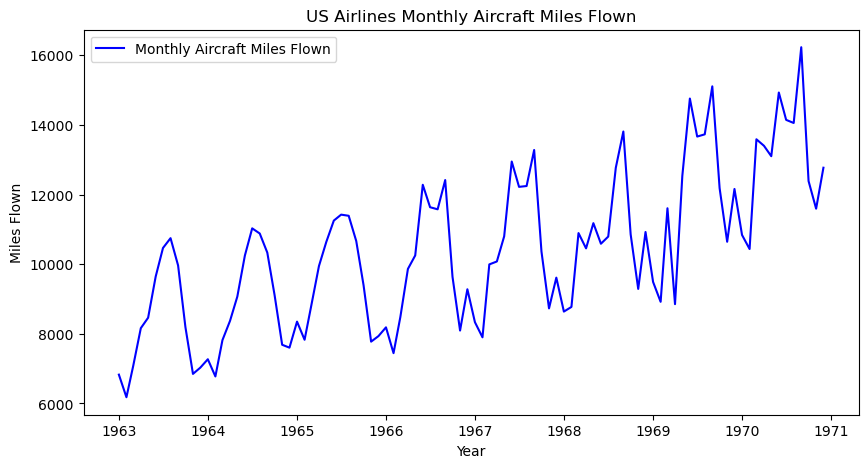

In [6]:
# plot the time series data
plt.figure(figsize=(10, 5))
plt.plot(df, label="Monthly Aircraft Miles Flown", color='blue')
plt.xlabel('Year')
plt.ylabel('Miles Flown')
plt.title('US Airlines Monthly Aircraft Miles Flown')
plt.legend()
plt.show()

In [8]:
# Check for stationary using ADF test
def adf_test(series):
    result=adfuller(series)
    print("ADF Statistic:", result[0])
    print('p-value:', result[1])
    if result[1]<=0.05:
        print('Data is stationary')
    else:
        print("Data is not stationary")
        
# Apply on the dataset
adf_test(df['MilesMM'])

ADF Statistic: 1.0229489778119767
p-value: 0.9945022811234028
Data is not stationary


In [9]:
# differencing to remove trend and seasonality
df['milesMM_diff']=df['MilesMM'].diff().dropna()
df['MilesMM_seasonal_diff']=df['MilesMM'].diff(12).dropna()

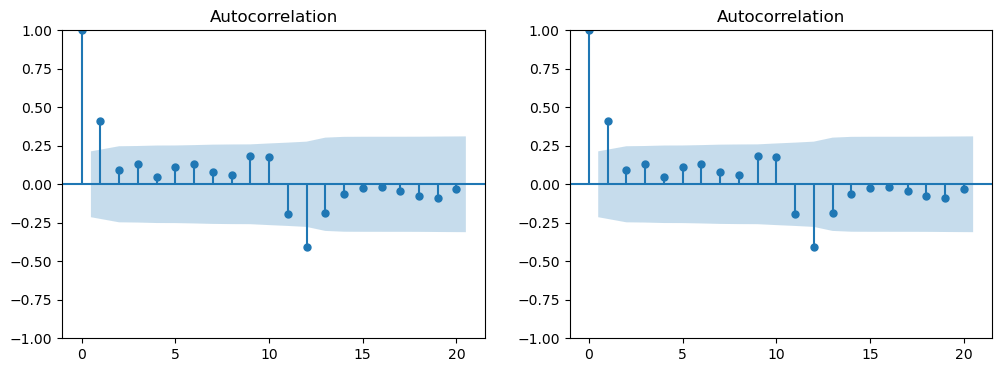

In [10]:
# plot ACF and PACF to identify paarmeters
fig,axes=plt.subplots(1,2,figsize=(12,4))
plot_acf(df['MilesMM_seasonal_diff'].dropna(), ax=axes[0])
plot_acf(df['MilesMM_seasonal_diff'].dropna(), ax=axes[1])
plt.show()

In [11]:
# define SARIMA Model (SARIMA(p,d,q)(P,D,Q,m))
p,d,q=1,1,1 # ARIMA order
P,D,Q,m=1,1,1,12 # Seasonal order

In [12]:
# find the SARIMA model
sarima_model=sm.tsa.statespace.SARIMAX(df['MilesMM'],
                                      order=(p,d,q),
                                      seasonal_order=(P,D,Q,m),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

C:\Users\yasha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\yasha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [13]:
sarima_result=sarima_model.fit()

In [14]:
# Model summary
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            MilesMM   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -559.576
Date:                            Tue, 01 Apr 2025   AIC                           1129.151
Time:                                    15:40:35   BIC                           1140.322
Sample:                                01-01-1963   HQIC                          1133.583
                                     - 12-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0870      0.161      0.540      0.589      -0.229       0.403
ma.L1         -0.7840      0.121   

In [15]:
# forecasting for next 24 months
future_steps=24
forecast=sarima_result.get_forecast(steps=future_steps)
forecast_index=pd.date_range(start=df.index[-1],periods=future_steps+1, freq="M")[1:]
forecast_index

DatetimeIndex(['1971-01-31', '1971-02-28', '1971-03-31', '1971-04-30',
               '1971-05-31', '1971-06-30', '1971-07-31', '1971-08-31',
               '1971-09-30', '1971-10-31', '1971-11-30', '1971-12-31',
               '1972-01-31', '1972-02-29', '1972-03-31', '1972-04-30',
               '1972-05-31', '1972-06-30', '1972-07-31', '1972-08-31',
               '1972-09-30', '1972-10-31', '1972-11-30', '1972-12-31'],
              dtype='datetime64[ns]', freq='M')

In [16]:
# Confidence interval
forecast_ci=forecast.conf_int()
forecast_ci

,lower MilesMM,upper MilesMM
1971-01-01,10032.925559,13165.431497
1971-02-01,9552.795582,12825.937800
1971-03-01,12226.361635,15586.401134
1971-04-01,10715.604206,14156.746097
1971-05-01,12545.863538,16065.936967
1971-06-01,14216.862396,17814.110101
1971-07-01,13381.504353,17054.302884
1971-08-01,13613.377912,17360.203988
1971-09-01,15139.349398,18958.768479
1971-10-01,11889.844656,15780.502517


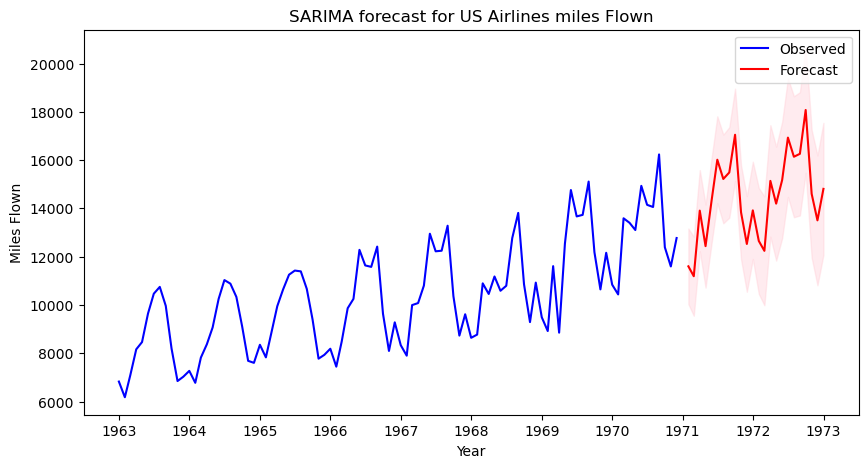

In [17]:
# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(df.index,df['MilesMM'], label="Observed",color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:,0],forecast_ci.iloc[:,1], color="pink", alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Miles Flown')
plt.title('SARIMA forecast for US Airlines miles Flown')
plt.legend()
plt.show()

In [18]:
adf_test(df['MilesMM'])

ADF Statistic: 1.0229489778119767
p-value: 0.9945022811234028
Data is not stationary


In [19]:
# Differencing to remove trend and seasonality
df['MilesMM_diff']=df['MilesMM'].diff().dropna()
df['MilesMM_seasonal_diff']=df['MilesMM'].diff(12).dropna()